In [119]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from string import punctuation
from imblearn.over_sampling import SMOTE

# AI models
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from nltk.tokenize import word_tokenize
import torch
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, StackingClassifier

In [120]:
# Import data
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = " ".join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text

test = pd.read_excel("data\\test.xlsx")
test['Msg'] = test['Msg'].apply(clean_text)

train = pd.read_excel("data\\train.xlsx")
train['Msg'] = train['Msg'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\valko\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [121]:
print(train['SentimentoClassificacao'].value_counts())
print("-------------------")
print(test['SentimentoClassificacao'].value_counts())

SentimentoClassificacao
 0    1114
-1     653
-2     262
 1     256
Name: count, dtype: int64
-------------------
SentimentoClassificacao
 0    936
-1    449
-2    292
 1    228
Name: count, dtype: int64


In [122]:
nan_counts = train.isna().sum()
print(nan_counts)
print("----------------------")
nan_counts = test.isna().sum()
print(nan_counts)

Dialog_ID                  0
SentimentoRegressao        0
SentimentoClassificacao    0
Msg                        0
dtype: int64
----------------------
Dialog_ID                  0
Msg                        0
Anotador1                  6
Anotador2                  2
SentimentoRegressao        0
SentimentoClassificacao    0
dtype: int64


In [123]:
y_test = test["SentimentoClassificacao"].values
x_test = test["Msg"].values
y_train = train["SentimentoClassificacao"].values
x_train = train["Msg"].values

In [124]:
# Representation of text using BERT
'''
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
def get_bert_embedding(texts):
    if isinstance(texts, str):
        texts = [texts]  
    elif not isinstance(texts, list) or not all(isinstance(t, str) for t in texts):
        raise ValueError("La entrada debe ser una cadena o una lista de cadenas.")
    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
    for key in inputs:
        inputs[key] = inputs[key].to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_vectors = outputs.last_hidden_state[:, 0, :] 
    return cls_vectors
x_train = x_train.tolist() if not isinstance(x_train, list) else x_train
x_test = x_test.tolist() if not isinstance(x_test, list) else x_test
x_train = get_bert_embedding(x_train)
x_test = get_bert_embedding(x_test)
'''

'\ntokenizer = BertTokenizer.from_pretrained("bert-base-uncased")\nmodel = BertModel.from_pretrained("bert-base-uncased")\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel.to(device)\ndef get_bert_embedding(texts):\n    if isinstance(texts, str):\n        texts = [texts]  \n    elif not isinstance(texts, list) or not all(isinstance(t, str) for t in texts):\n        raise ValueError("La entrada debe ser una cadena o una lista de cadenas.")\n    inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512)\n    for key in inputs:\n        inputs[key] = inputs[key].to(device)\n    with torch.no_grad():\n        outputs = model(**inputs)\n    cls_vectors = outputs.last_hidden_state[:, 0, :] \n    return cls_vectors\nx_train = x_train.tolist() if not isinstance(x_train, list) else x_train\nx_test = x_test.tolist() if not isinstance(x_test, list) else x_test\nx_train = get_bert_embedding(x_train)\nx_test = get_bert_embedding(x_test)

In [125]:
# Representation of text using Bag-Of-Words

vectorizer = CountVectorizer()
x_train = vectorizer.fit_transform(x_train)
x_test = vectorizer.transform(x_test)


In [126]:
# Representation of text using Word2Vec
'''
nltk.download('punkt_tab')

train_sentences = [word_tokenize(text.lower()) for text in x_train]
test_sentences = [word_tokenize(text.lower()) for text in x_test]
model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)
def get_sentence_vector(sentence):
    tokens = word_tokenize(sentence.lower())
    word_vectors = [model.wv[token] for token in tokens if token in model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
x_train = np.array([get_sentence_vector(text) for text in x_train])
x_test = np.array([get_sentence_vector(text) for text in x_test])
'''

"\nnltk.download('punkt_tab')\n\ntrain_sentences = [word_tokenize(text.lower()) for text in x_train]\ntest_sentences = [word_tokenize(text.lower()) for text in x_test]\nmodel = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)\ndef get_sentence_vector(sentence):\n    tokens = word_tokenize(sentence.lower())\n    word_vectors = [model.wv[token] for token in tokens if token in model.wv]\n    if word_vectors:\n        return np.mean(word_vectors, axis=0)\n    else:\n        return np.zeros(model.vector_size)\nx_train = np.array([get_sentence_vector(text) for text in x_train])\nx_test = np.array([get_sentence_vector(text) for text in x_test])\n"

In [127]:
# Representation of text using TF-IDF 
'''
print(f"x_train dataset length: {len(x_train)}")

vectorizer = TfidfVectorizer(max_features=100)
x_train = vectorizer.fit_transform(x_train.astype(str))
x_test = vectorizer.transform(x_test.astype(str))
'''

'\nprint(f"x_train dataset length: {len(x_train)}")\n\nvectorizer = TfidfVectorizer(max_features=100)\nx_train = vectorizer.fit_transform(x_train.astype(str))\nx_test = vectorizer.transform(x_test.astype(str))\n'

In [128]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
x_train, y_train = smote.fit_resample(x_train, y_train)
print(f"resized x_train dataset length: {x_train.shape[0]}")

resized x_train dataset length: 4456


In [129]:
x_train_2, x_val, y_train_2, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [130]:
weights = ['uniform', 'distance']
for k in range(1, 11):
    for w in weights:
        clf = KNeighborsClassifier(n_neighbors=k, weights=w)
        clf.fit(x_train_2, y_train_2)
        y_pred = clf.predict(x_val)
        accuracy = round(accuracy_score(y_val, y_pred)*100, 2)
        print(f"Accuracy of KNN for k={k} and w={w}: {accuracy}%")
    print("\n")
print("The best hyperparameters for Bag-of-Words are k=1 & w=uniform with 54.15%")
print("The best hyperparameters for Word2Vec are k=2 & w=distance with 79.37%")
print("The best hyperparameters for TF-IDF are k=1 & w=distance with 60.99%")

Accuracy of KNN for k=1 and w=uniform: 54.15%
Accuracy of KNN for k=1 and w=distance: 54.15%


Accuracy of KNN for k=2 and w=uniform: 45.29%
Accuracy of KNN for k=2 and w=distance: 47.2%


Accuracy of KNN for k=3 and w=uniform: 49.89%
Accuracy of KNN for k=3 and w=distance: 51.68%


Accuracy of KNN for k=4 and w=uniform: 49.55%
Accuracy of KNN for k=4 and w=distance: 51.79%


Accuracy of KNN for k=5 and w=uniform: 48.43%
Accuracy of KNN for k=5 and w=distance: 51.35%


Accuracy of KNN for k=6 and w=uniform: 47.42%
Accuracy of KNN for k=6 and w=distance: 50.0%


Accuracy of KNN for k=7 and w=uniform: 45.85%
Accuracy of KNN for k=7 and w=distance: 48.32%


Accuracy of KNN for k=8 and w=uniform: 45.52%
Accuracy of KNN for k=8 and w=distance: 49.1%


Accuracy of KNN for k=9 and w=uniform: 43.83%
Accuracy of KNN for k=9 and w=distance: 47.76%


Accuracy of KNN for k=10 and w=uniform: 43.72%
Accuracy of KNN for k=10 and w=distance: 47.87%


The best hyperparameters for Bag-of-Words are k=1 &

In [131]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for c in range(1, 21):
    for k in kernels:
        clf = SVC(C=c, kernel=k)
        clf.fit(x_train_2, y_train_2)
        y_pred = clf.predict(x_val)
        accuracy = round(accuracy_score(y_val, y_pred)*100, 2)
        print(f"Accuracy of SVM for c={c} and kernel={k}: {accuracy}%")
    print("\n")
print("The best hyperparameters for Bag-of-Words are c=1 & kernel=rbf with 58.18%")
print("The best hyperparameters for Word2Vec are c=20 & kernel=rbf with 53.59%")
print("The best hyperparameters for TF-IDF are c=9 & kernel=rbf with 67.26%")

Accuracy of SVM for c=1 and kernel=linear: 55.27%
Accuracy of SVM for c=1 and kernel=poly: 38.0%
Accuracy of SVM for c=1 and kernel=rbf: 58.18%
Accuracy of SVM for c=1 and kernel=sigmoid: 53.14%


Accuracy of SVM for c=2 and kernel=linear: 55.61%
Accuracy of SVM for c=2 and kernel=poly: 39.57%
Accuracy of SVM for c=2 and kernel=rbf: 56.39%
Accuracy of SVM for c=2 and kernel=sigmoid: 53.48%


Accuracy of SVM for c=3 and kernel=linear: 55.72%
Accuracy of SVM for c=3 and kernel=poly: 42.04%
Accuracy of SVM for c=3 and kernel=rbf: 56.17%
Accuracy of SVM for c=3 and kernel=sigmoid: 53.14%


Accuracy of SVM for c=4 and kernel=linear: 55.49%
Accuracy of SVM for c=4 and kernel=poly: 43.83%
Accuracy of SVM for c=4 and kernel=rbf: 55.61%
Accuracy of SVM for c=4 and kernel=sigmoid: 52.47%


Accuracy of SVM for c=5 and kernel=linear: 55.49%
Accuracy of SVM for c=5 and kernel=poly: 43.39%
Accuracy of SVM for c=5 and kernel=rbf: 55.61%
Accuracy of SVM for c=5 and kernel=sigmoid: 52.13%


Accuracy of

In [132]:
criterions = ['gini', 'entropy', 'log_loss']

for criterion in criterions:
	for depth in range(1, 21):
		tree = DecisionTreeClassifier(criterion=criterion, max_depth=depth)
		tree.fit(x_train_2, y_train_2)
		y_pred = tree.predict(x_val)
		accuracy = round(accuracy_score(y_val, y_pred)*100, 2)
		print(f"Accuracy for criterion={criterion} and depth={depth}: {accuracy}%")
	print("\n")
print("The best hyperparameters for Bag-of-Words are criterion=gini & depth=19 with 46.86%")
print("The best hyperparameters for Word2Vec are criterion=gini & depth=19 with 66.7%")
print("The best hyperparameters for TF-IDF are criterion=log_loss & depth=19 with 56.28%")

Accuracy for criterion=gini and depth=1: 26.79%
Accuracy for criterion=gini and depth=2: 30.16%
Accuracy for criterion=gini and depth=3: 31.84%
Accuracy for criterion=gini and depth=4: 34.87%
Accuracy for criterion=gini and depth=5: 36.77%
Accuracy for criterion=gini and depth=6: 38.45%
Accuracy for criterion=gini and depth=7: 39.35%
Accuracy for criterion=gini and depth=8: 39.8%
Accuracy for criterion=gini and depth=9: 41.26%
Accuracy for criterion=gini and depth=10: 41.59%
Accuracy for criterion=gini and depth=11: 41.48%
Accuracy for criterion=gini and depth=12: 42.15%
Accuracy for criterion=gini and depth=13: 43.5%
Accuracy for criterion=gini and depth=14: 45.07%
Accuracy for criterion=gini and depth=15: 44.96%
Accuracy for criterion=gini and depth=16: 45.4%
Accuracy for criterion=gini and depth=17: 45.63%
Accuracy for criterion=gini and depth=18: 45.96%
Accuracy for criterion=gini and depth=19: 46.75%
Accuracy for criterion=gini and depth=20: 46.3%


Accuracy for criterion=entropy 

In [133]:
knn = KNeighborsClassifier(n_neighbors=1, weights="uniform")
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
print(f"Accuracy of KNN: {accuracy}%")
print(classification_report(y_test, y_pred))

svm = SVC(C=1, kernel="rbf")
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
print(f"Accuracy of SVM: {accuracy}%")
print(classification_report(y_test, y_pred))

tree = DecisionTreeClassifier(criterion="gini", max_depth=19)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
print(f"Accuracy of tree: {accuracy}%")
print(classification_report(y_test, y_pred))

Accuracy of KNN: 35.38%
              precision    recall  f1-score   support

          -2       0.27      0.41      0.33       292
          -1       0.30      0.47      0.37       449
           0       0.59      0.33      0.42       936
           1       0.15      0.16      0.15       228

    accuracy                           0.35      1905
   macro avg       0.33      0.34      0.32      1905
weighted avg       0.42      0.35      0.36      1905

Accuracy of SVM: 46.46%
              precision    recall  f1-score   support

          -2       0.36      0.19      0.25       292
          -1       0.40      0.36      0.38       449
           0       0.58      0.65      0.61       936
           1       0.21      0.28      0.24       228

    accuracy                           0.46      1905
   macro avg       0.39      0.37      0.37      1905
weighted avg       0.46      0.46      0.46      1905

Accuracy of tree: 29.19%
              precision    recall  f1-score   support

  

In [134]:
# Random Forest
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
y_pred = random_forest.predict(x_test)
accuracy_rf = round(accuracy_score(y_test, y_pred) * 100, 2)
print(f"Accuracy for Random Forest: {accuracy}%")
print(classification_report(y_test, y_pred))

# Bagging Classifier
bagging = BaggingClassifier()
bagging.fit(x_train, y_train)
y_pred_bagging = bagging.predict(x_test)
accuracy_bagging = round(accuracy_score(y_test, y_pred_bagging) * 100, 2)
print(f"Accuracy for Bagging: {accuracy_bagging}%")
print(classification_report(y_test, y_pred_bagging))

Accuracy for Random Forest: 29.19%
              precision    recall  f1-score   support

          -2       0.48      0.32      0.38       292
          -1       0.36      0.45      0.40       449
           0       0.67      0.51      0.58       936
           1       0.21      0.39      0.27       228

    accuracy                           0.45      1905
   macro avg       0.43      0.42      0.41      1905
weighted avg       0.51      0.45      0.47      1905

Accuracy for Bagging: 43.83%
              precision    recall  f1-score   support

          -2       0.38      0.26      0.31       292
          -1       0.37      0.41      0.39       449
           0       0.64      0.53      0.58       936
           1       0.19      0.36      0.25       228

    accuracy                           0.44      1905
   macro avg       0.39      0.39      0.38      1905
weighted avg       0.48      0.44      0.45      1905



In [135]:
logistic = LogisticRegression()
logistic.fit(x_train, y_train)
y_pred = logistic.predict(x_test)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
print(f"Accuracy for Logistic: {accuracy}%")
print(classification_report(y_test, y_pred))

perceptron = Perceptron()
perceptron.fit(x_train, y_train)
y_pred = perceptron.predict(x_test)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
print(f"Accuracy for Perceptron: {accuracy}%")
print(classification_report(y_test, y_pred))

Accuracy for Logistic: 43.52%
              precision    recall  f1-score   support

          -2       0.31      0.23      0.26       292
          -1       0.38      0.46      0.42       449
           0       0.62      0.51      0.56       936
           1       0.21      0.35      0.26       228

    accuracy                           0.44      1905
   macro avg       0.38      0.39      0.37      1905
weighted avg       0.47      0.44      0.44      1905

Accuracy for Perceptron: 42.41%
              precision    recall  f1-score   support

          -2       0.27      0.22      0.24       292
          -1       0.33      0.47      0.38       449
           0       0.62      0.52      0.57       936
           1       0.20      0.20      0.20       228

    accuracy                           0.42      1905
   macro avg       0.35      0.35      0.35      1905
weighted avg       0.44      0.42      0.43      1905



In [136]:
bernoulli = BernoulliNB()
bernoulli.fit(x_train, y_train)
y_pred = bernoulli.predict(x_test)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
print(f"Accuracy of bernoulliNB: {accuracy}%")
print(classification_report(y_test, y_pred))

multi = MultinomialNB()
multi.fit(x_train, y_train)
y_pred = multi.predict(x_test)
accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
print(f"Accuracy of multinomialNB: {accuracy}%")
print(classification_report(y_test, y_pred))

Accuracy of bernoulliNB: 38.01%
              precision    recall  f1-score   support

          -2       0.33      0.39      0.36       292
          -1       0.33      0.34      0.34       449
           0       0.73      0.32      0.45       936
           1       0.22      0.68      0.34       228

    accuracy                           0.38      1905
   macro avg       0.41      0.43      0.37      1905
weighted avg       0.52      0.38      0.40      1905

Accuracy of multinomialNB: 49.34%
              precision    recall  f1-score   support

          -2       0.43      0.38      0.40       292
          -1       0.34      0.50      0.40       449
           0       0.76      0.57      0.65       936
           1       0.27      0.33      0.29       228

    accuracy                           0.49      1905
   macro avg       0.45      0.44      0.44      1905
weighted avg       0.55      0.49      0.51      1905



In [141]:
# Stacking Classifier (usando Logistic Regression y Random Forest como modelos base)
stacking = StackingClassifier(
    estimators=[
        ('logistic', LogisticRegression()),		# 51.39% accuracy 
        ('svm', SVC(C=1, kernel="rbf")),		# 88% precision for -2
        ("tree", DecisionTreeClassifier(criterion="gini", max_depth=19)),	# 42% precision for -1
        ("Bernoulli", BernoulliNB()),			# 75% precision for 0
        ("Multinomial", MultinomialNB())		# 70% precision for 1
    ],
    final_estimator=SVC(C=1, kernel="rbf")
)
stacking.fit(x_train, y_train)
y_pred_stacking = stacking.predict(x_test)
accuracy_stacking = round(accuracy_score(y_test, y_pred_stacking) * 100, 2)
print(f"Accuracy for Stacking: {accuracy_stacking}%")
print(classification_report(y_test, y_pred_stacking))

Accuracy for Stacking: 47.3%
              precision    recall  f1-score   support

          -2       0.38      0.18      0.25       292
          -1       0.39      0.37      0.38       449
           0       0.58      0.67      0.62       936
           1       0.22      0.25      0.23       228

    accuracy                           0.47      1905
   macro avg       0.39      0.37      0.37      1905
weighted avg       0.46      0.47      0.46      1905



In [138]:
x_train_dense = x_train.toarray() if hasattr(x_train, "toarray") else x_train
y_train_dense = y_train.toarray() if hasattr(y_train, "toarray") else y_train
x_test_dense = x_test.toarray() if hasattr(x_test, "toarray") else x_test
y_test_dense = y_test.toarray() if hasattr(y_test, "toarray") else y_test

gauss = GaussianNB()
gauss.fit(x_train_dense, y_train_dense)
y_pred = gauss.predict(x_test_dense)
accuracy = round(accuracy_score(y_test_dense, y_pred)*100, 2)
print(f"Accuracy of gaussianNB: {accuracy}%")
print(classification_report(y_test, y_pred))

Accuracy of gaussianNB: 41.84%
              precision    recall  f1-score   support

          -2       0.29      0.21      0.24       292
          -1       0.32      0.44      0.37       449
           0       0.58      0.47      0.52       936
           1       0.31      0.41      0.35       228

    accuracy                           0.42      1905
   macro avg       0.37      0.38      0.37      1905
weighted avg       0.44      0.42      0.42      1905



As we can see the best classfier is the Decision Tree with a 55.7% of accuracy using TF-IDF

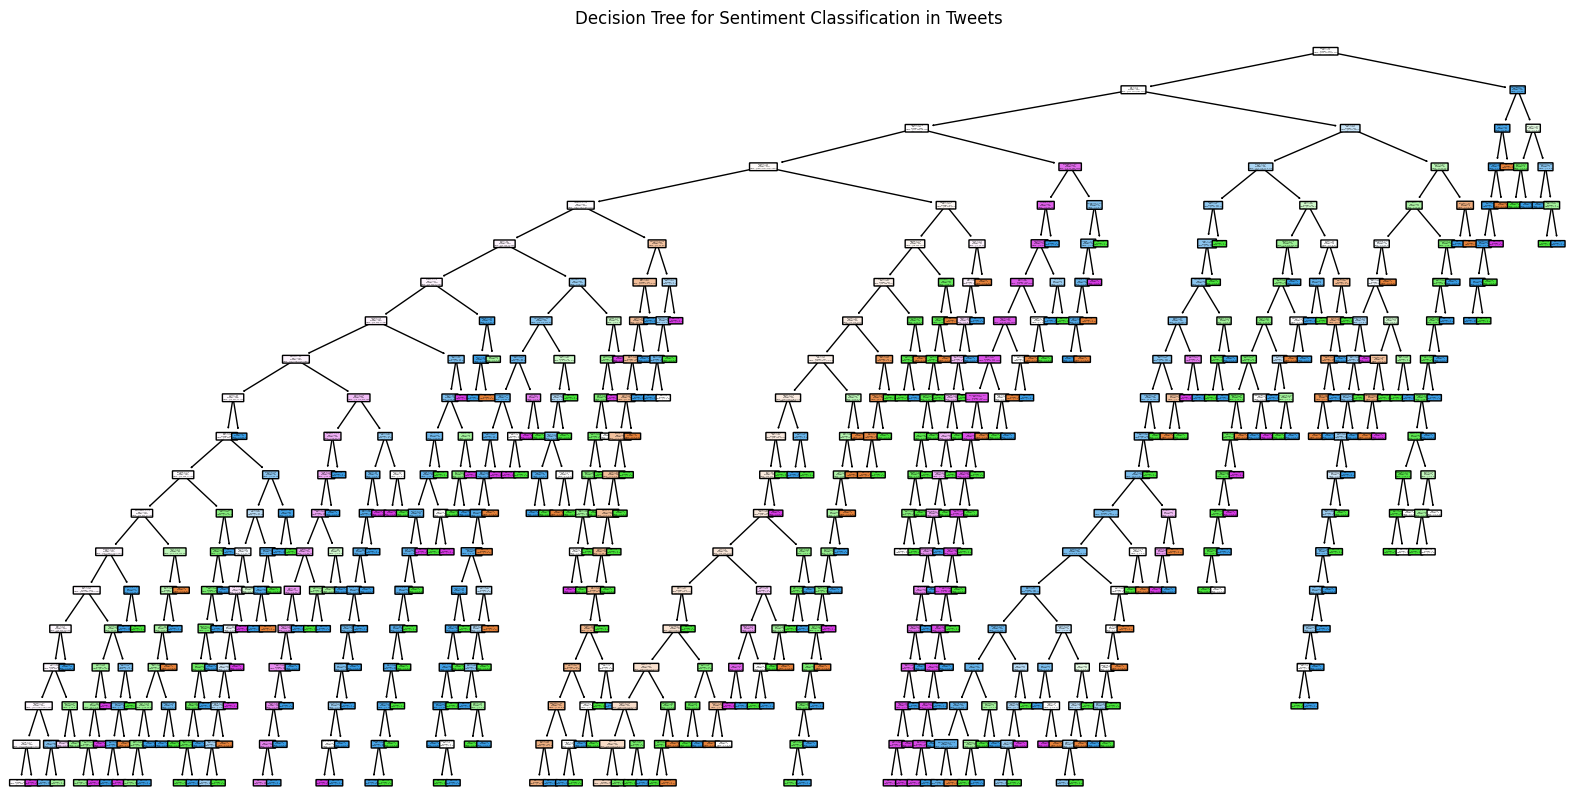

In [139]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
import pandas as pd

feature_names = vectorizer.get_feature_names_out()
x_train_df = pd.DataFrame.sparse.from_spmatrix(x_train, columns=feature_names)

plt.figure(figsize=(20, 10))
plot_tree(
    tree,
    filled=True,
    feature_names=x_train_df.columns, 
    class_names=['Very Negative', 'Negative', 'Neutral', 'Positive'],
    rounded=True
)
plt.title("Decision Tree for Sentiment Classification in Tweets")
plt.show()


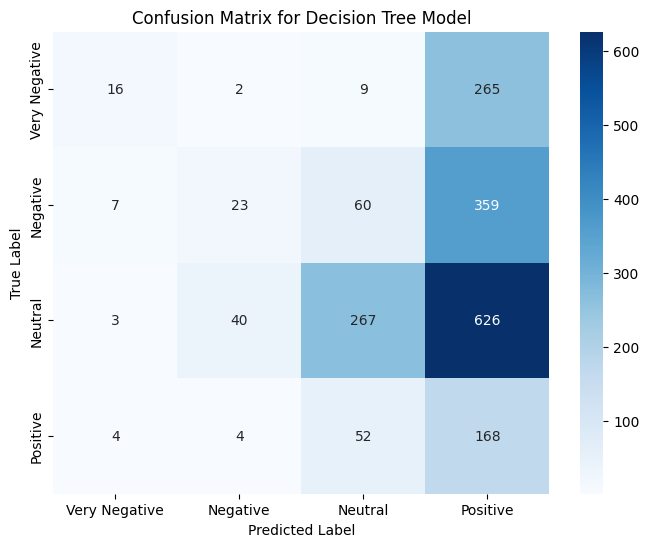

In [140]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
tree = DecisionTreeClassifier(criterion='log_loss', max_depth=9)
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
# Generar matriz de confusión
cm = confusion_matrix(y_test, y_pred, labels=[-2, -1, 0, 1])

# Visualizar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Very Negative', 'Negative', 'Neutral', 'Positive'],
            yticklabels=['Very Negative', 'Negative', 'Neutral', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Decision Tree Model")
plt.show()

